In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def generate_sbm_adjacency_matrix(community_sizes, probability_matrix):
    np.random.seed(123)  # Set seed for reproducibility
    
    # Calculate the total number of nodes
    num_nodes = sum(community_sizes)

    # Initialize the adjacency matrix with zeros
    adjacency_matrix = np.zeros((num_nodes, num_nodes))
    
    # Create a list of community labels for each node
    community_labels = []
    for community_index, size in enumerate(community_sizes):
        community_labels.extend([community_index] * size)
    
    # Generate the adjacency matrix based on the probability matrix
    for i in range(num_nodes):
        for j in range(num_nodes):
            community_i = community_labels[i]
            community_j = community_labels[j]

            # Get the probability of an edge between nodes i and j based on their communities
            prob = probability_matrix[community_i, community_j]

            # Add an edge with probability `prob`
            if np.random.rand() < prob:
                adjacency_matrix[i, j] = 1

    return community_labels, adjacency_matrix


In [4]:
###CREATE NECESSARY FUNCTIONS

# Define excitation function psi using a modified log-sum-exp function with clipping to avoid overflow
def psi(x):
    return np.clip(np.log(1 + np.exp(x)), None, 40)

#Redefine poisson_randomness function to take E as an argument
def poisson_randomness(lmbd, E):
    i = 0
    S = 0  
    while S <= lmbd:  
        i += 1
        S += E[i]  
    return i - 1 

    # Define different types of kernels and return their values at times 1 to some chosen values t
def exponential_kernel(kernel_params, t):
    alpha, beta = kernel_params
    return alpha * np.exp(-beta * t)

def power_law_kernel(kernel_params, t):
    alpha, beta = kernel_params
    return alpha * (t ** (-beta))

def rayleigh_kernel(kernel_params, t):
    alpha, beta = kernel_params
    return alpha * t * np.exp(-beta * t**2)

def gaussian_kernel(kernel_params, t):
    alpha, beta = kernel_params
    return alpha * np.exp(-0.5 * ((t - beta) ** 2))

def sigmoid_kernel(kernel_params, t):
    alpha, beta = kernel_params
    return np.tanh(alpha * t + beta)

In [45]:
sigmoid_kernel([0.0001, 0.0005], 1)

np.float64(0.0005999999280000104)

In [44]:
gaussian_kernel(kernel_params, 1)

np.float64(0.7942472123261359)

In [5]:
alpha = 0.9
beta = 0.5
t_values = np.arange(100, 0, -1)
kernel_params = [alpha,beta]
power_law_kernel(kernel_params, t_values)[99:]

#power_law_kernel(kernel_params, 1)

array([0.9])

In [6]:
## LAMBDA EVOLUTION FUNCTIONS

def lmbd_next_sbm_comb(N,T, G, X, t, kernel_values, mu):
    lmbd_next = psi(mu + np.dot(G, np.sum(kernel_values[T-t:, :] * X[:t, :], axis=0)) / N)
    return lmbd_next

def lmbd_next_sb_mf(lmbd, T, t, lab, comm_size, prob_matrix, kernel_values, mu_vector = [0.5, 0.5, 0.5]):

    # Extract the probabilities of connection for certain community
    prob = prob_matrix[:, lab]

    # Compute alpha values
    alphas = comm_size/np.sum(comm_size)
    lmbd_next = psi(mu_vector[lab] + np.dot(alphas* prob, np.sum(kernel_values[T-t+1:,:] * lmbd[:t,:], axis = 0)))

    return lmbd_next

In [7]:

#Simulating Hawkes with SBM structure
def simulate_comb_sbm(E, T, num_nodes, comm_size, kernel_function, kernel_params, G, mu_vector = np.array([0.2, 0.2, 0.2])):
    t_values = np.arange(T, 0, -1)
    kernel_values = np.zeros((T, num_nodes))
    for i in range(num_nodes):
        kernel_values[:, i] = kernel_function(kernel_params, t_values)

    if len(mu_vector) != comm_size.shape[0]:
        raise ValueError("The length of mu_vector must match the number of communities in comm_size.")

    mu_vector_expanded = np.zeros(num_nodes)
    start_idx = 0
    for i, size in enumerate(comm_size):
        mu_vector_expanded[start_idx:start_idx + size] = mu_vector[i]
        start_idx += size

    # Initializing the matrices
    N = np.zeros((T, num_nodes))
    lmbd = np.zeros((T, num_nodes))
    X = np.zeros((T, num_nodes))

    #Settting in itial values
    lmbd[0, :] = np.full(num_nodes, psi(mu_vector[0]))
    X[0, :] = np.zeros(num_nodes)
    
    for i in range(1, T):
        for j in range(num_nodes):
            lmbd[i, j] = psi(mu_vector_expanded[j] + np.dot(G[j, :], np.sum(kernel_values[T-i:, :] * X[:i, :], axis=0)) / num_nodes)
            X[i, j] = poisson_randomness(lmbd[i, j],E[i,j, :])
            N[i, j] = N[i-1, j] + X[i, j]
            N[i, j] = N[i-1, j] + X[i, j]

    return N, lmbd, X

In [8]:
def simulate_mf_sbm(E, T, comm_size, prob_matrix, kernel_function, kernel_params, mu_vector = np.array([0.2,0.2, 0.2])):
    num_comm = len(comm_size)
    alphas = comm_size/np.sum(comm_size)
    t_values = np.arange(T,0, -1)
    
    kernel_values = np.zeros((T, num_comm))
    for i in range(num_comm):
        kernel_values[:, i] = kernel_function(kernel_params, t_values)


    # Initialize vectors to store values for the simulation
    N = np.zeros((T, num_comm))
    lmbd = np.zeros((T, num_comm))
    X = np.zeros((T, num_comm))   

    # Set initial values for lambda and counts
    X[0, :] = np.zeros(num_comm)
    N[0, :] = X[0, :]
    lmbd[0, :] = psi(mu_vector)

    # Run the simulation for each time step
    for i in range(1, T):
        for j in range(num_comm):
            lmbd[i, j] = psi(mu_vector[j] + np.dot(alphas* prob_matrix[:,j], np.sum(kernel_values[T-i:,:] * lmbd[:i,:], axis = 0)))

            # Simulate the Poisson process for the current time step
            X[i] = poisson_randomness(lmbd[i,j],  E[i, j, :])
        
            # Update the cumulative count of events
            N[i] = N[i - 1] + X[i]
    
    print(i)

    return N, lmbd, X


In [21]:
#Example community
num_nodes = 1000
comm_size = np.array([500,300,200])
prob_matrix = np.array([[0.9, 0.1, 0.1],
                               [0.1, 0.7, 0.8],
                               [0.1, 0.8, 0.3]])

alphas = comm_size/num_nodes

T = 1000
E = np.random.exponential(scale = 1.0, size = (T, num_nodes, 20))
labs, G = generate_sbm_adjacency_matrix(comm_size, prob_matrix)

In [238]:
alphas

array([0.5, 0.3, 0.2])

In [14]:

N_comb, lmbd_comb ,X_comb = simulate_comb_sbm(E, T,num_nodes,comm_size, gaussian_kernel, [0.9, 0.5], G)



In [15]:
N_mf, lmbd_mf, X_mf = simulate_mf_sbm(E, T, comm_size, prob_matrix, gaussian_kernel, [0.9, 0.5])

99


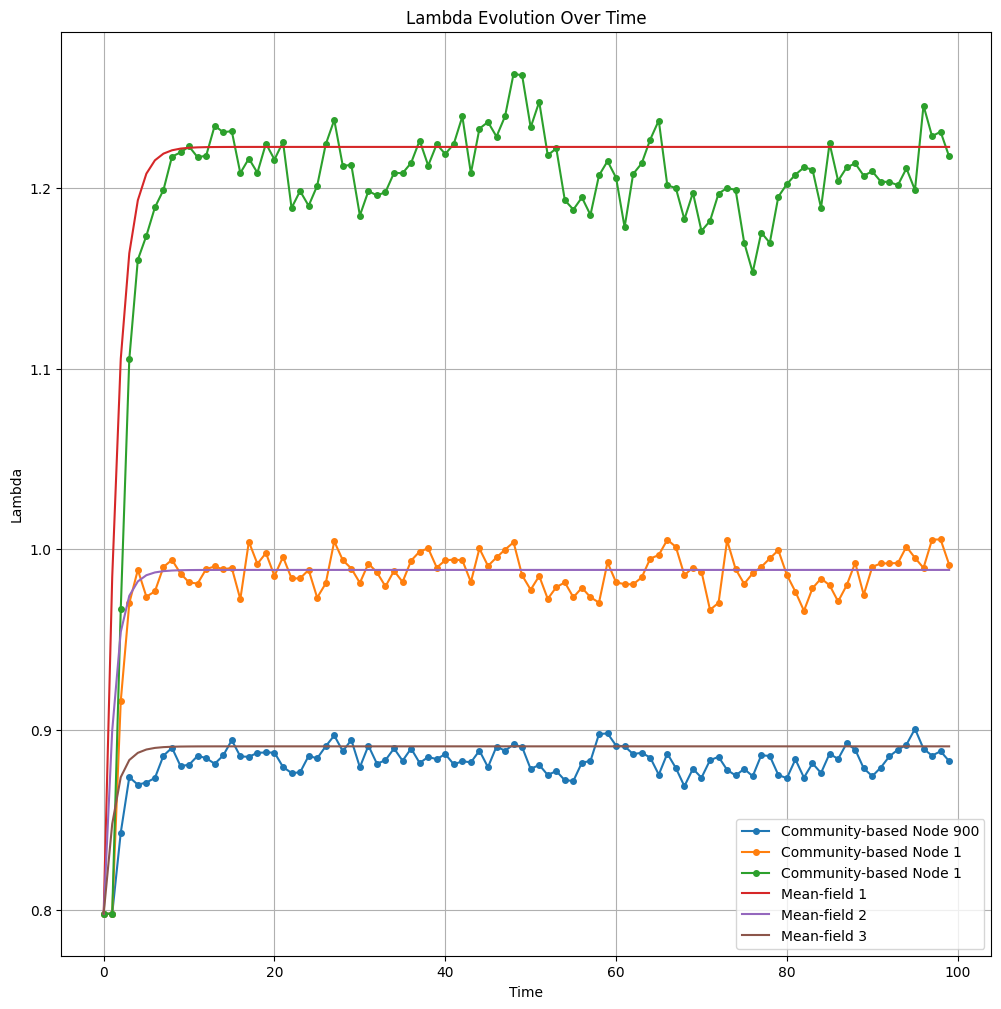

In [16]:
plt.figure(figsize=(12, 12))
plt.plot(lmbd_comb[:, 959], marker='o', markersize=4, label='Community-based Node 900')
plt.plot(lmbd_comb[:, 600], marker='o', markersize=4, label='Community-based Node 1')
plt.plot(lmbd_comb[:, 1], marker='o', markersize=4, label='Community-based Node 1')
#plt.plot(lmbd_comb[:, 20], marker='o', markersize=4, label='Community-based Node 1')
plt.plot(lmbd_mf[:, 0], markersize=4, label='Mean-field 1')
plt.plot(lmbd_mf[:, 1], markersize=4, label='Mean-field 2')
plt.plot(lmbd_mf[:, 2], markersize=4, label='Mean-field 3')

plt.title('Lambda Evolution Over Time')
plt.xlabel('Time')
plt.ylabel('Lambda')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
def plot_sbm_simulation_results_3_groups(num_nodes1, num_nodes2, prob_matrix, prop, T, kernel_function, kernel_params, label):
    """
    Creates a plot with three subplots to visualize the lambda values for three different groups 
    in a stochastic block model (SBM) simulation.

    Parameters:
        num_nodes1 (int): Number of nodes in the smaller network size for SBM simulation.
        num_nodes2 (int): Number of nodes in the larger network size for SBM simulation.
        prob_matrix (ndarray): Probability matrix for intra- and inter-community connections.
        prop (list): Proportion of nodes in each community (should sum to 1).
        T (int): Number of time steps for the simulation.

    Returns:
        None: The function displays the plot and saves it as a PDF file.
    """

    # Calculate community sizes based on proportions for the smaller network
    comm_size = (num_nodes1 * prop).astype(int)

    # Simulate from SBM for the first network size
    E = np.random.exponential(scale=1.0, size=(T, num_nodes1, 15))  # Generate random exponential variables for simulation
    labs, G = generate_sbm_adjacency_matrix(comm_size, prob_matrix)
    N_comb, lmbd_comb ,X_comb = simulate_comb_sbm(E, T,num_nodes1,comm_size, kernel_function, kernel_params, G)

    # Indices for different groups in the first network size
    group1_index = 0
    group2_index = comm_size[0] + 1
    group3_index = comm_size[0] + comm_size[1] + 1

    # Simulate mean-field approximations for different groups
    N_mf, lmbd_mf, X_mf = simulate_mf_sbm(E, T, comm_size, prob_matrix, kernel_function, kernel_params)

    # Calculate community sizes based on proportions for the larger network
    comm_size = (num_nodes2 * prop).astype(int)

    # Indices for different groups in the larger network size
    group1_index2 = 0
    group2_index2 = comm_size[0] + 1
    group3_index2 = comm_size[0] + comm_size[1] + 1

    # Simulate from SBM for the second, larger network size
    E = np.random.exponential(scale = 1.0, size = (T, num_nodes2, 20))  # Generate random exponential variables for simulation
    labs, G = generate_sbm_adjacency_matrix(comm_size, prob_matrix)
    N_comb_more, lmbd_comb_more, X_comb = simulate_comb_sbm(E, T,num_nodes2,comm_size, kernel_function, kernel_params, G)

    # Create a figure with 3 subplots arranged horizontally
    fig, axs = plt.subplots(1, 3, figsize=(20, 7), sharex=True)

    # Plot the data for Group 1 in the first subplot
    axs[0].plot(lmbd_mf[:,0], '--', markersize=2, label='Group 1 Mean-Field', color='red')
    axs[0].plot(lmbd_comb[:, group1_index], 'o', markersize=2, label='Group 1 Original Process', color='blue')
    axs[0].plot(lmbd_comb_more[:, group1_index2], 'o', markersize=2, label='Group 1 Original Process', color='orange')
    axs[0].set_ylabel('Intensity', fontsize=14)
    axs[0].set_title(r'$C_1$', fontsize=16)
    axs[0].set_xlabel('Time', fontsize=14)
    axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Plot the data for Group 2 in the second subplot
    axs[1].plot(lmbd_mf[:,1], '--', markersize=2, label='Group 2 Mean-Field', color='black')
    axs[1].plot(lmbd_comb[:, group2_index], 'o', markersize=2, label='Group 2 Original Process', color='deepskyblue')
    axs[1].plot(lmbd_comb_more[:, group2_index2], 'o', markersize=2, label='Group 2 Original Process', color='goldenrod')
    axs[1].set_ylabel('Intensity', fontsize=14)
    axs[1].set_xlabel('Time', fontsize=14)
    axs[1].set_title(r'$C_2$', fontsize=16)
    axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Plot the data for Group 3 in the third subplot
    axs[2].plot(lmbd_mf[:, 2], '--', markersize=2, label='Group 3 Mean-Field', color='brown')
    axs[2].plot(lmbd_comb[:, group3_index], 'o', markersize=2, label='Group 3 Original Process', color='purple')
    axs[2].plot(lmbd_comb_more[:, group3_index2], 'o', markersize=2, label='Group 3 Original Process', color='green')
    axs[2].set_xlabel('Time', fontsize=14)
    axs[2].set_ylabel('Intensity', fontsize=14)
    axs[2].set_title(r'$C_3$', fontsize=16)
    axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the figure
    plt.savefig(label)

    # Show the plot
    plt.show()


In [23]:
plot_sbm_simulation_results_3_groups(100, 1000, prob_matrix, np.array([0.5, 0.3, 0.2]), T, gaussian_kernel, kernel_params)

TypeError: plot_sbm_simulation_results_3_groups() missing 1 required positional argument: 'label'

99


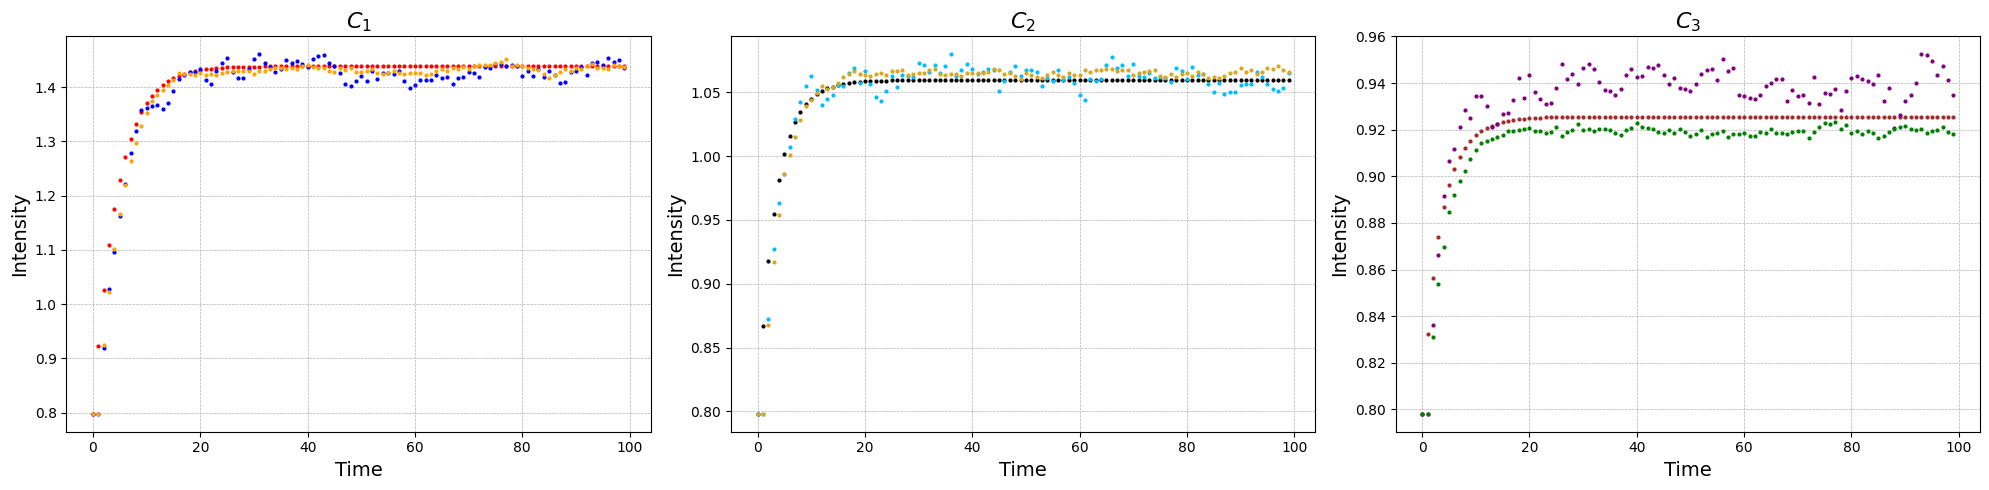

In [ ]:
plot_sbm_simulation_results_3_groups(1000, 10000, prob_matrix, np.array([0.5, 0.3, 0.2]), T, exponential_kernel, kernel_params, 'three-class-exponential.pdf')

999


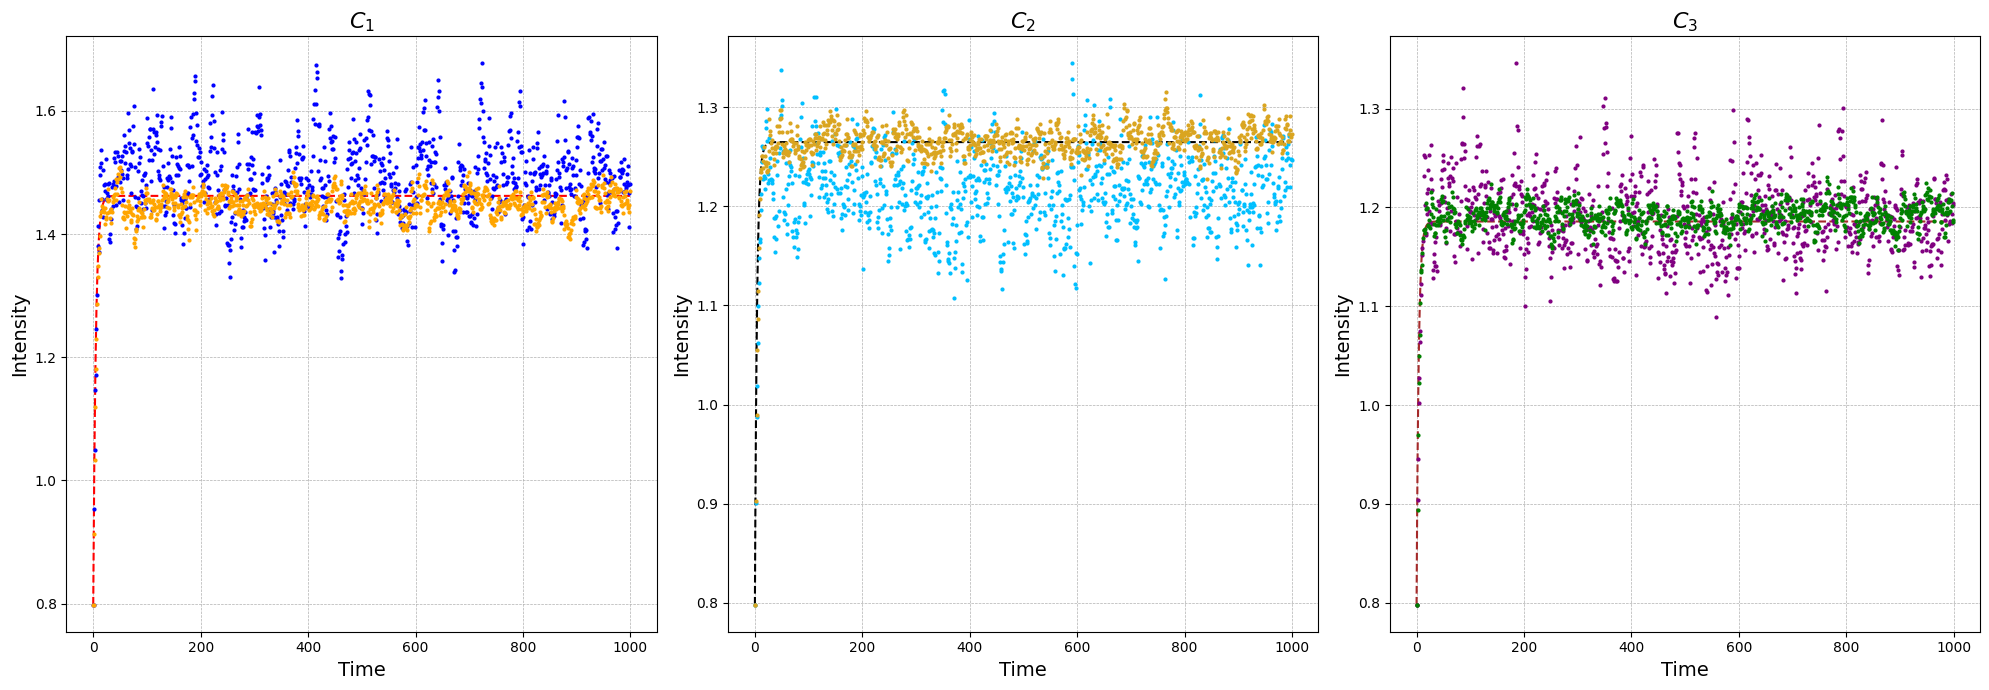

In [25]:
plot_sbm_simulation_results_3_groups(100, 1000, prob_matrix, np.array([0.5, 0.3, 0.2]), 1000, exponential_kernel, kernel_params, 'three-class-exponential.pdf')

999


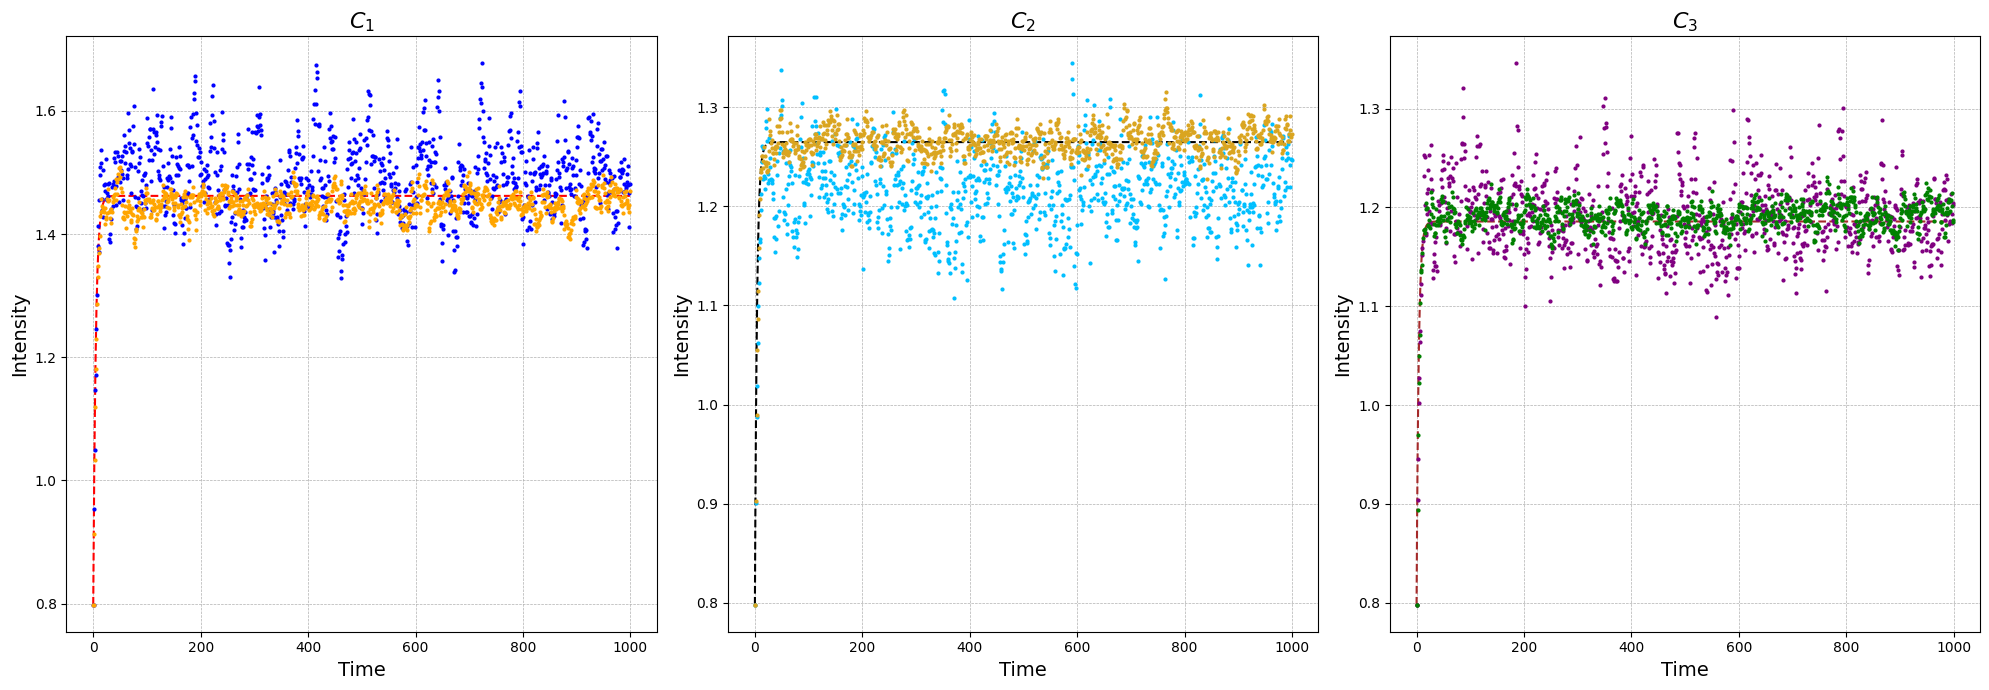

In [26]:
plot_sbm_simulation_results_3_groups(100, 1000, prob_matrix, np.array([0.5, 0.3, 0.2]), 1000, exponential_kernel, kernel_params, 'three-class-gaussian.pdf')

In [105]:
#Calculate the Mean Squared Error (MSE) between the combined process and the mean-field approximation 
# over a range of time steps (T) or a range of node counts (N).

def calculate_norms(prob_matrix, prop, N, it, kernel_function, kernel_params):
    # Initialize list to store MSE values
    two_norms = []
    infinity_norms = []

    range_values = np.arange(10, it, 20)
    # Iterate over the specified range
    for value in range_values:
        if N == False:
            T = value
            num_nodes = 500  # Default number of nodes
        elif N == True:
            T = 500  # Default time step value
            num_nodes = value
        else:
            raise ValueError("iterate_over should be 'T' or 'N'")
        
        print(num_nodes)
        comm_size = (num_nodes * prop).astype(int)
        num_nodes = np.sum(comm_size)
        E = np.random.exponential(scale = 1.0, size = (T, num_nodes, 15))
        labs, G = generate_sbm_adjacency_matrix(comm_size, prob_matrix)

        # Simulate the combined process and mean-field approximation
        N_comb, lmbd_comb ,X_comb = simulate_comb_sbm(E, T,num_nodes,comm_size, kernel_function, kernel_params, G)
        N_mf, lmbd_mf, X_mf = simulate_mf_sbm(E, T, comm_size, prob_matrix, kernel_function, kernel_params)

        start_idx = 0
        lmbd_mf_expanded = np.zeros_like(lmbd_comb)
        for i, size in enumerate(comm_size):
            lmbd_mf_expanded[:, start_idx:start_idx + size] = np.tile(lmbd_mf[:, i].reshape(-1, 1), size)
            start_idx += size

        #Calculate matrix norms
        two_norm = np.linalg.norm(np.abs(lmbd_comb - lmbd_mf_expanded), ord=2)
        infinity_norm = np.linalg.norm(np.abs(lmbd_comb - lmbd_mf_expanded), ord=np.inf) 

        two_norms.append(two_norm)
        infinity_norms.append(infinity_norm)

    return two_norms, infinity_norms


In [109]:

two_norms_N, infinity_norms_N = calculate_norms(prob_matrix, alphas,True, 1000, exponential_kernel, kernel_params)

10
499
30
499
50
499
70
499
90
499
110
499
130
499
150
499
170
499
190
499
210
499
230
499
250
499
270
499
290
499
310
499
330
499
350
499
370
499
390
499
410
499
430
499
450
499
470
499
490
499
510
499
530
499
550
499
570
499
590
499
610
499
630
499
650
499
670
499
690
499
710
499
730
499
750
499
770
499
790
499
810
499
830
499
850
499
870
499
890
499
910
499
930
499
950
499
970
499
990
499


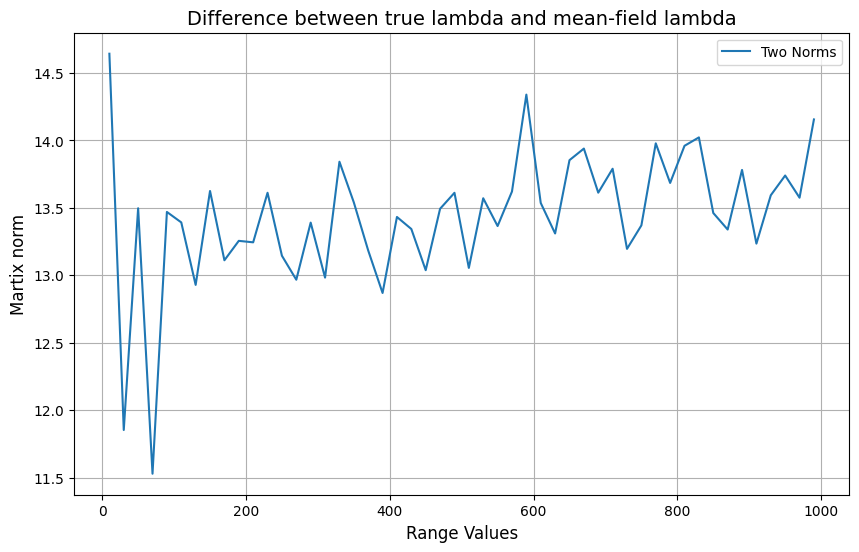

In [115]:
range_values = np.arange(10, 1000, 20)
plt.figure(figsize=(10, 6))
plt.plot(range_values, two_norms_N, label='Two Norms')
plt.xlabel('Range Values', fontsize=12)
plt.ylabel('Martix norm', fontsize=12)
plt.title('Difference between true lambda and mean-field lambda', fontsize=14)
plt.legend()
plt.grid(True)
plt.savefig('N_values.pdf')
plt.show()

#plt.plot(range_values, infinity_norms_N)

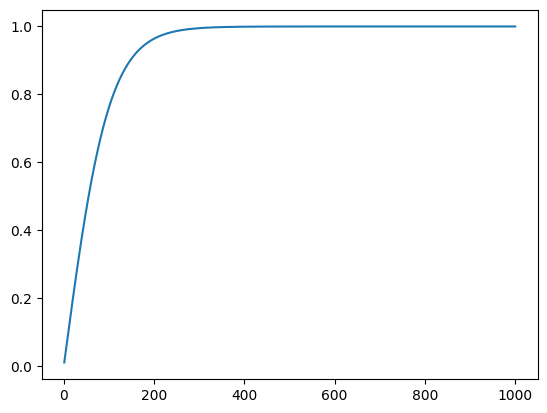

In [ ]:
def plot_NT(chosen_index, prob, N_values, T_values):
    """
    Plot Mean Absolute Deviation (MAD) against the number of nodes (N) and final time (T).

    Parameters:
        chosen_index (int): Index of the chosen node for comparison.
        prob (list): List of probabilities for the random matrix generation.
        N_values (list or array): Range of node counts (N) to iterate over.
        T_values (list or array): Range of time steps (T) to iterate over.

    Returns:
        None: The function saves the plot as a PDF file and displays it.
    """

    #Calculate mse_values
    mse_values = calculate_mse(chosen_index, prob, True, N_values)
    mse_values_T = calculate_mse(chosen_index, prob, False, T_values)

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot MSE with increasing N
    ax1.plot(N_values, mse_values, marker='o', label='MSE')
    ax1.plot(N_values, mse_values[0] / np.sqrt(N_values/N_values[0]), marker='x', linestyle='--', label='Scaling')
    ax1.set_xlabel('N', fontsize=14)
    ax1.legend(fontsize=12)
    ax1.grid(True)
    ax1.set_title('MAD vs N', fontsize=16)

    # Plot MSE with increasing T
    ax2.plot(T_values[1:], mse_values_T[1:], marker='o')
    ax2.set_xlabel('Final time', fontsize=14)
    ax2.grid(True)
    ax2.set_title('MAD vs T', fontsize=16)

    # Adjust layout to avoid overlapping
    plt.tight_layout()

    # Save and display the figure
    plt.savefig('mse_NT.pdf')
    plt.show()
